# Importações

In [214]:
#!pip install swig                                                              # Instala pacotes necessários para o uso do Gym
#!pip install gymnasium[box2d]                                                  # Instala pacotes necessários para o uso do Gym
import gymnasium as gym                                                         # Importa a biblioteca do gymnasium
import numpy as np                                                              # Importa a biblioteca do numpy
import heapq                                                                    # Importa a biblioteca da pilha
import matplotlib.pyplot as plt                                                 # Importa a biblioteca Matplotlib para visualização de dados
import imageio                                                                  # Importa a biblioteca imageio para ler arquivos de imagem
from IPython.display import display, Image                                      # Importa as funções display para exibir objetos no colab e Image para carregar imagens de arquivos

# Funções auxilizares e do A*

In [215]:
def neighbors(pos, map, n_cols, n_rows):                                        # Função que retorna as posições adjacentes a uma posição
    moves = [(-1,0), (1,0), (0,-1), (0,1)]                                      # Esq, dir, cima, baixo
    result = []                                                                 # Lista de posições possíveis
    for dx, dy in moves:                                                        # Percorre as posições possíveis
        nx, ny = pos[0] + dx, pos[1] + dy                                       # Posição final após o movimento
        if 0 <= nx < n_rows and 0 <= ny < n_cols:                               # Se a nova posição está dento dos limites do mapa
            if map[nx][ny] != 'H':                                              # Verifica se a nova posição evita buracos
                result.append((nx, ny))                                         # Adiciona a nova posição a lista de posições possíveis
    return result                                                               # Retorna a lista de posições possíveis

In [216]:
def find_pos(letra, n_cols, n_rows, map):                                       # Função que localiza uma posição única no mapa
    for i in range(n_rows):                                                     # Percorre as linhas do mapa
        for j in range(n_cols):                                                 # Percorre as colunas do mapa
            if map[i][j] == letra:                                              # Verifica se a posição atual é a posição desejada
                return (i, j)                                                   # Se sim, retorna a posição

A função **_get_caminho_** ordena, do início até a chegada, todos os pontos percorridos com base na lista de "**_caminho_total_**". Esse trecho do código será utilizado para obter a resposta completa após atingir o objetivo.

* **caminho_total:** Lista de coordenadas de pontos percorridos;
* **current_pos:** coordenada do ponto atual.

In [217]:
def get_caminho(caminho_total, current_pos):
    temp_path = [current_pos]                                                   # lista temporaria dos pontos
    while current_pos in caminho_total:
        current_pos = caminho_total[current_pos]                                # Recupera ponto anterior
        temp_path.append(current_pos)                                           # Adiciona a lista

    return temp_path[::-1]                                                      # Inverte a lista

# Implementação das funções

## Implementação da função heurística

Essa função será utilizada para calcular a estimativa de custo entre dois pontos do mapa usando a distância Manhattan para um mapa bidimensional:


d = |x₁ − x₂| + |y₁ − y₂|

In [218]:
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

## Implementação da função de custo

Função destinada ao cálculo do custo de real desde o inicio e levando em consideração o custo do bloco seguinte com base no tipo de bloco.

In [219]:
def cost_function(acc_cost, map_custo, a, b, map):

    celula_a = map[a[0]][a[1]]      # Bloco anterior
    celula_b = map[b[0]][b[1]]      # Bloco seguinte

    return acc_cost + map_custo[celula_b]

## Implementação do algorítmo **_A*_**

O algoritmo A* foi implementado com base no pseudo código disponível no artigo da Wikipédia e no repositório do projeto desenvolvido por [Malu Freitas](https://github.com/malufreitas) e [Tarcisio Bruni](https://github.com/tarcisiobruni). O link para ambos os projetos pode ser encontrado nas referências dessa atividade.


In [220]:
def a_star(start, goal,map_custos, map, n_cols, n_rows):
    open_set = [(0, start)]

    caminho_total = {}                                                          # Dicionário para rastrear o caminho
    custo_total = {start: 0}                                                    # Custo do início até cada bloco

    while open_set:
        current_cost, current_pos = heapq.heappop(open_set)

        if current_pos == goal:
            #Se chegou ao detino, tracar percurso
            return get_caminho(caminho_total, current_pos)

        for neighbor in neighbors(current_pos, map, n_cols, n_rows):
            temp_custo_total = custo_total[current_pos] + cost_function(custo_total[current_pos], map_custos, current_pos, neighbor, map)

            #Busca o melhor caminho entre os nos vizinhos
            if neighbor not in custo_total or temp_custo_total < custo_total[neighbor]:
                caminho_total[neighbor] = current_pos
                custo_total[neighbor] = temp_custo_total
                custo_estm = temp_custo_total + heuristic(neighbor, goal)
                heapq.heappush(open_set, (custo_estm, neighbor))

    return None  # Caminho não encontrado

# Funções auxiliares para o Gym

In [221]:
def to_action(curr, next):                                                      # Função que mapeia posições para ações do Gym
    dx = next[0] - curr[0]
    dy = next[1] - curr[1]
    if dx == -1: return 3  # cima
    if dx == 1: return 1   # baixo
    if dy == -1: return 0  # esquerda
    if dy == 1: return 2   # direita

# Atividade 01 - Reposta

Implementação simples do algoritmo A*, com apenas um tipo de terreno, seguindo o mapa de custo 1.

In [222]:
map_custo_bloco1 = {
    'F': 1,                     # Bloco de gelo    = 1
    'H': float('inf'),          # Bloco com buraco = custo infinito
    'S': 1,                     # Posição inicial  = 1
    'G': 0                      # Posição final
}

In [223]:
# --- Configuração do ambiente determinístico ---
map1 = ["FFFFFFFS",                                                             # Desenho do mapa do ambiente
        "FHFHHHHH",                                                             # F é a parte congelada onde se pode andar
        "FHFFHFFF",                                                             # H é a parte com buracos onde não se pode andar
        "FHFFFFHF",                                                             # S é a posição inicial e G é a posição final
        "FHFHHHFF",
        "FHFFFHFH",
        "FHFHFHHH",
        "FFFHFFFG"]

map1_rows = 8                                                                   # Número de linhas do mapa
map1_cols = 8                                                                   # Número de colunas do mapa
env = gym.make("FrozenLake-v1", desc=map1, is_slippery=False, render_mode="rgb_array") # Cria o mapa
env.reset()                                                                     # Reinicia o mapa
frames = []                                                                     # Lista de frames para a animação

start_map1 = find_pos('S', map1_cols, map1_rows, map1)                          # Localiza a posição inicial no mapa
goal_map1 = find_pos('G', map1_cols, map1_rows, map1)                           # Localiza a posição final no mapa

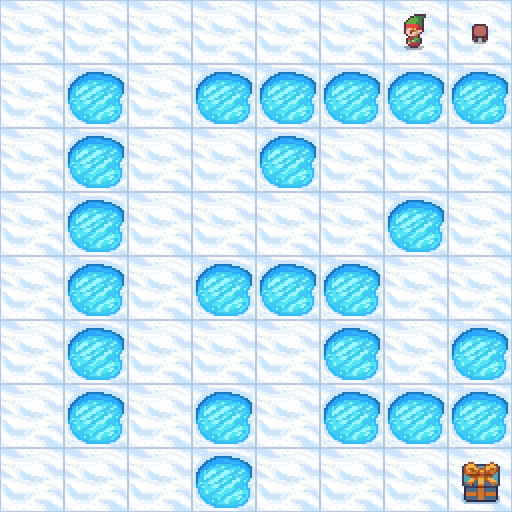

In [224]:
path = a_star(start_map1, goal_map1, map_custo_bloco1, map1, map1_cols, map1_rows) # Executar o A* da posição inicial ao objetivo e retorna o caminho encontrado

# Movimenta o agente conforme o caminho encontrado
env.reset()
for i in range(1, len(path)):                                                   # Executar todas as ações do caminho
    action = to_action(path[i-1], path[i])                                      # Determina a ação tomada entre duas posições do caminho
    env.step(action)                                                            # Executa a ação no ambiente
    frames.append(env.render())                                                 # Adiciona a imagem atual do mapa à lista de frames
env.close()                                                                     # Fecha o ambiente

# Criar e exibir GIF do movimento do agente no ambiente
imageio.mimsave("Walk.gif", frames, duration=1.0)                               # Gera um gif a partir das imagens geradas de todas as tentativas
display(Image(filename="Walk.gif"))                                             # Exibe o gif gerado

# Atividade 02 - Reposta

Implementação simples do algoritmo A*, com vários tipos de terrenos, com base no segundo mapa de custo. Observe que, apesar de existir outros caminhos, o agente tende a ir pelo que representa um menor custo de percusso, otimizando o trajeto.

In [225]:
map_custo_bloco2 = {
    'F': 1,                     # Bloco de gelo      = 1
    'H': float('inf'),          # Bloco com buraco   = custo infinito
    'A': 4,                     # Bloco de gelo fino = 4  //NOVO
    'N': 2,                     # Bloco de neve      = 2  //NOVO
    'S': 1,                     # Posição inicial    = 1
    'G': 0                      # Posição final
}

A função **_map_adapter_** é utilizada apenas para substituir os novos blocos para exibir graficamente o caminho encontrado.

In [226]:
def map_adapter(map):
    return [linha.replace('A', 'F').replace('N', 'F') for linha in map]


In [227]:
# --- Configuração do ambiente determinístico ---

map2 = ["FFFFAFAS",                                                             # Desenho do mapa do ambiente
        "FAFHHHHH",
        "HANFHFFF",
        "FHAFFFAF",
        "HNFHHHFF",
        "FHFFFNFH",
        "FHFHFHHH",
        "FFFHFFFG"]


map2_rows = 8                                                                   # Número de linhas do mapa
map2_cols = 8                                                                   # Número de colunas do mapa

env2 = gym.make("FrozenLake-v1", desc=map_adapter(map2), is_slippery=False, render_mode="rgb_array") # Cria o mapa
env2.reset()                                                                    # Reinicia o mapa
frames = []                                                                     # Lista de frames para a animação

start_map2 = find_pos('S', map2_cols, map2_rows,map2)                           # Localiza a posição inicial no mapa
goal_map2 = find_pos('G', map2_cols, map2_rows,map2)                            # Localiza a posição final no mapa

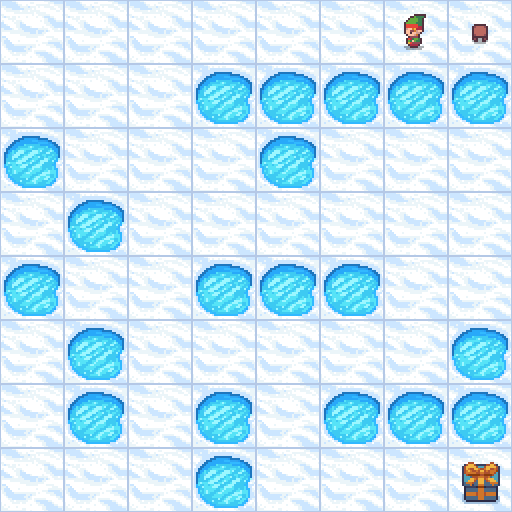

In [229]:
path2 = a_star(start_map2, goal_map2, map_custo_bloco2, map2, map2_cols, map2_rows) # Executar o A* da posição inicial ao objetivo e retorna o caminho encontrado

# Movimenta o agente conforme o caminho encontrado
env2.reset()
for i in range(1, len(path)):                                                   # Executar todas as ações do caminho
    action = to_action(path[i-1], path[i])                                      # Determina a ação tomada entre duas posições do caminho
    env2.step(action)                                                           # Executa a ação no ambiente
    frames.append(env2.render())                                                # Adiciona a imagem atual do mapa à lista de frames
env2.close()                                                                    # Fecha o ambiente

# Criar e exibir GIF do movimento do agente no ambiente
imageio.mimsave("Walk2.gif", frames, duration=1.0)                              # Gera um gif a partir das imagens geradas de todas as tentativas
display(Image(filename="Walk2.gif"))                                            # Exibe o gif gerado


# Referências:

Os seguintes projetos e artigos a seguir foram utilizados como referência para a implementação do projeto.

* [Algoritmo A* (Github)](https://github.com/malufreitas/a-estrela)
* [Algoritmo A* Wikipedia](https://pt.wikipedia.org/wiki/Algoritmo_A*#:~:text=Algoritmo%20A*%20(L%C3%AA-se,inicial%20at%C3%A9%20um%20v%C3%A9rtice%20final.)
* [Caminhos baratos de custo mínimo](https://www.ime.usp.br/~pf/algoritmos_para_grafos/aulas/cheapestpaths.html)
* [A estrutura heap](https://www.ime.usp.br/~pf/analise_de_algoritmos/aulas/heap.html)
